# ATLAS RPV CNN Classifier

Mostly taken from Michela's Keras implementation here: https://github.com/mickypaganini/susy_rpv/blob/micky/train.py

In [1]:
# GPU selection
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
from __future__ import print_function
from __future__ import division

import h5py
import numpy as np

from keras import layers, models, callbacks
from keras import backend as K

from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib notebook

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Global configuration

In [3]:
# Data config
n_train = 412416
n_valid = 137471
n_test = 137471

## Load the data

In [4]:
input_dir = '/bigdata/shared/atlas_rpv/atlas-rpv-images'

In [5]:
ls -lh $input_dir

total 1.8G
-rw-rw---- 1 sfarrell gpu-users 358M Apr 24 14:32 test.h5
-rw-rw---- 1 sfarrell gpu-users 1.1G Apr 24 14:32 train.h5
-rw-rw---- 1 sfarrell gpu-users 358M Apr 24 14:32 val.h5


In [6]:
def load_file(file, n_samples):
    print('Loading file', file)
    with h5py.File(file) as f:
        data_group = f['all_events']
        print('Loading %i/%i events' %
              (n_samples, data_group['hist'].shape[0]))
        data = data_group['hist'][:n_samples][:,:,:,None]
        labels = data_group['y'][:n_samples]
        weights = data_group['weight'][:n_samples]
    return data, labels, weights

In [7]:
%%time

train_file = os.path.join(input_dir, 'train.h5')
valid_file = os.path.join(input_dir, 'val.h5')
test_file = os.path.join(input_dir, 'test.h5')

train_input, train_labels, train_weights = load_file(train_file, n_train)
valid_input, valid_labels, valid_weights = load_file(valid_file, n_valid)
test_input, test_labels, test_weights = load_file(test_file, n_test)

Loading file /bigdata/shared/atlas_rpv/atlas-rpv-images/train.h5
Loading 412416/412416 events
Loading file /bigdata/shared/atlas_rpv/atlas-rpv-images/val.h5
Loading 137471/137471 events
Loading file /bigdata/shared/atlas_rpv/atlas-rpv-images/test.h5
Loading 137471/137471 events
CPU times: user 1min 20s, sys: 1min 7s, total: 2min 27s
Wall time: 2min 27s


In [8]:
print('train shape:', train_input.shape)
print('valid shape:', valid_input.shape)
print('test shape: ', test_input.shape)

train shape: (412416, 64, 64, 1)
valid shape: (137471, 64, 64, 1)
test shape:  (137471, 64, 64, 1)


## Define the model

In [9]:
def build_model(input_shape, optimizer='adam'):
    inputs = layers.Input(shape=input_shape)
    h = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', strides=1, padding='same')(inputs)
    h = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', strides=2, padding='same')(h)
    h = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', strides=1, padding='same')(h)
    h = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', strides=2, padding='same')(h)
    h = layers.Flatten()(h)
    h = layers.Dense(512, activation='relu')(h)
    outputs = layers.Dense(1, activation='sigmoid')(h)
    model = models.Model(inputs, outputs, 'RPVClassifier')
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

## Train the model

In [10]:
# Training config
batch_size = 256
n_epochs = 5
use_weights = False

In [11]:
model = build_model(train_input.shape[1:])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               33554944  
__________

In [12]:
fit_args = dict(x=train_input, y=train_labels,
                batch_size=batch_size, epochs=n_epochs,
                validation_data=(valid_input, valid_labels))
if use_weights:
    fit_args.update(sample_weight=train_weights,
                    validation_data=(valid_input, valid_labels, valid_weights))
history = model.fit(**fit_args)

Train on 412416 samples, validate on 137471 samples
Epoch 1/5
412416/412416 [==============================] - 422s 1ms/step - loss: 0.2388 - acc: 0.9036 - val_loss: 0.2282 - val_acc: 0.9081
Epoch 2/5
412416/412416 [==============================] - 413s 1ms/step - loss: 0.2266 - acc: 0.9088 - val_loss: 0.2151 - val_acc: 0.9143
Epoch 3/5
412416/412416 [==============================] - 412s 998us/step - loss: 0.1391 - acc: 0.9459 - val_loss: 0.0322 - val_acc: 0.9888
Epoch 4/5
412416/412416 [==============================] - 412s 998us/step - loss: 0.0315 - acc: 0.9888 - val_loss: 0.0282 - val_acc: 0.9899
Epoch 5/5
412416/412416 [==============================] - 412s 998us/step - loss: 0.0250 - acc: 0.9910 - val_loss: 0.0289 - val_acc: 0.9899


## Evaluate on the test set

In [17]:
def summarize_metrics(labels, outputs, threshold=0.5, weights=None):
    preds = outputs > threshold
    
    print('Metrics summaries with threshold of %.3f' % threshold)
    print('Accuracy:   %.4f' % metrics.accuracy_score(labels, preds, sample_weight=weights))
    print('Purity:     %.4f' % metrics.precision_score(labels, preds, sample_weight=weights))
    print('Efficiency: %.4f' % metrics.recall_score(labels, preds, sample_weight=weights))

    fpr, tpr, _ = metrics.roc_curve(labels, outputs, sample_weight=weights)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

In [14]:
test_output = model.predict(test_input)
test_output = test_output.squeeze(-1)

Metrics summaries with threshold of 0.500
Accuracy:   0.9898
Purity:     0.9874
Efficiency: 0.9889


<IPython.core.display.Javascript object>


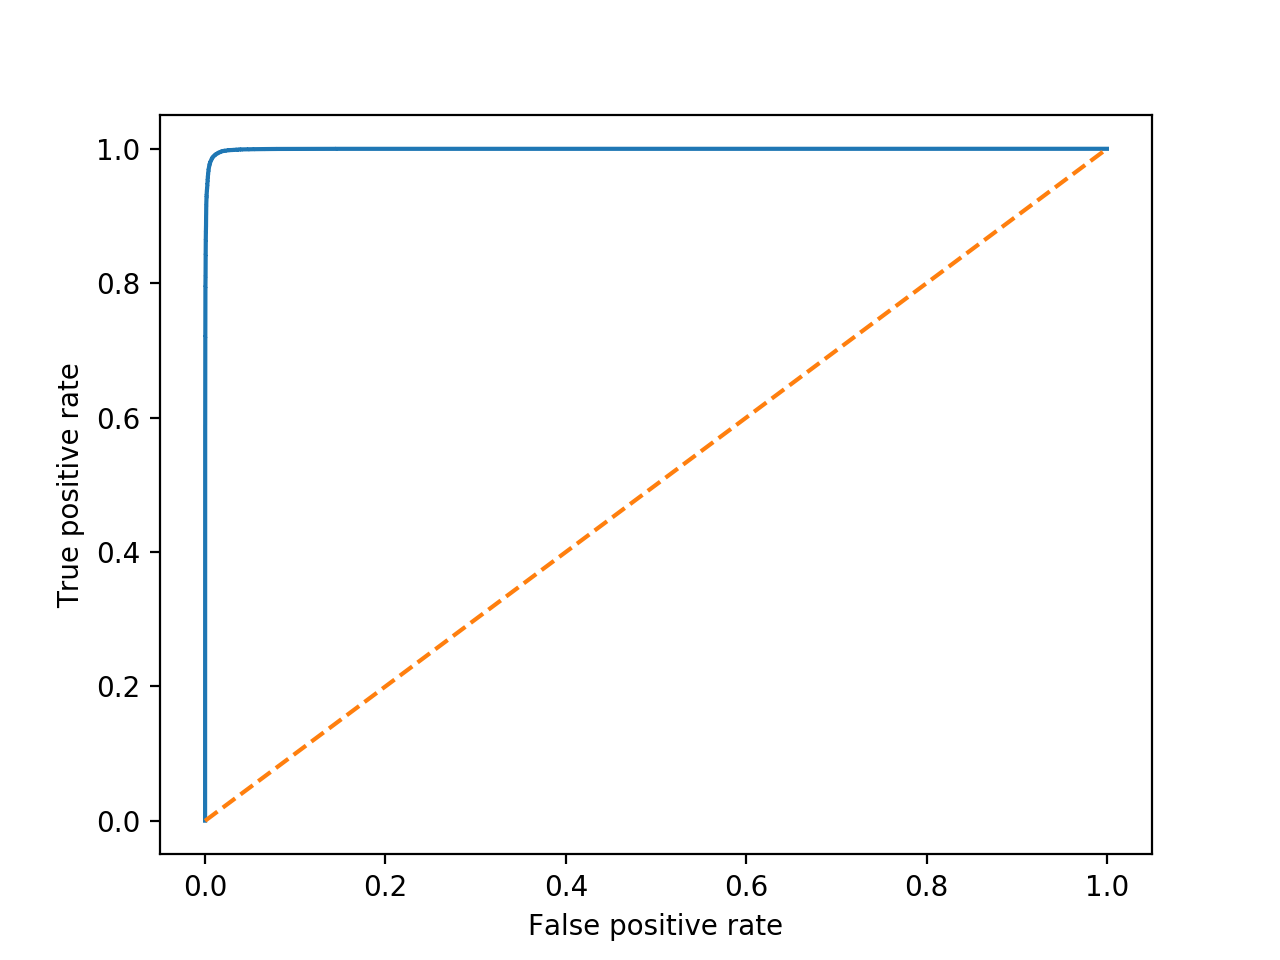

In [18]:
# Unweighted results
summarize_metrics(test_labels, test_output)

Metrics summaries with threshold of 0.999
Accuracy:   1.0000
Purity:     0.8536
Efficiency: 0.6613


<IPython.core.display.Javascript object>


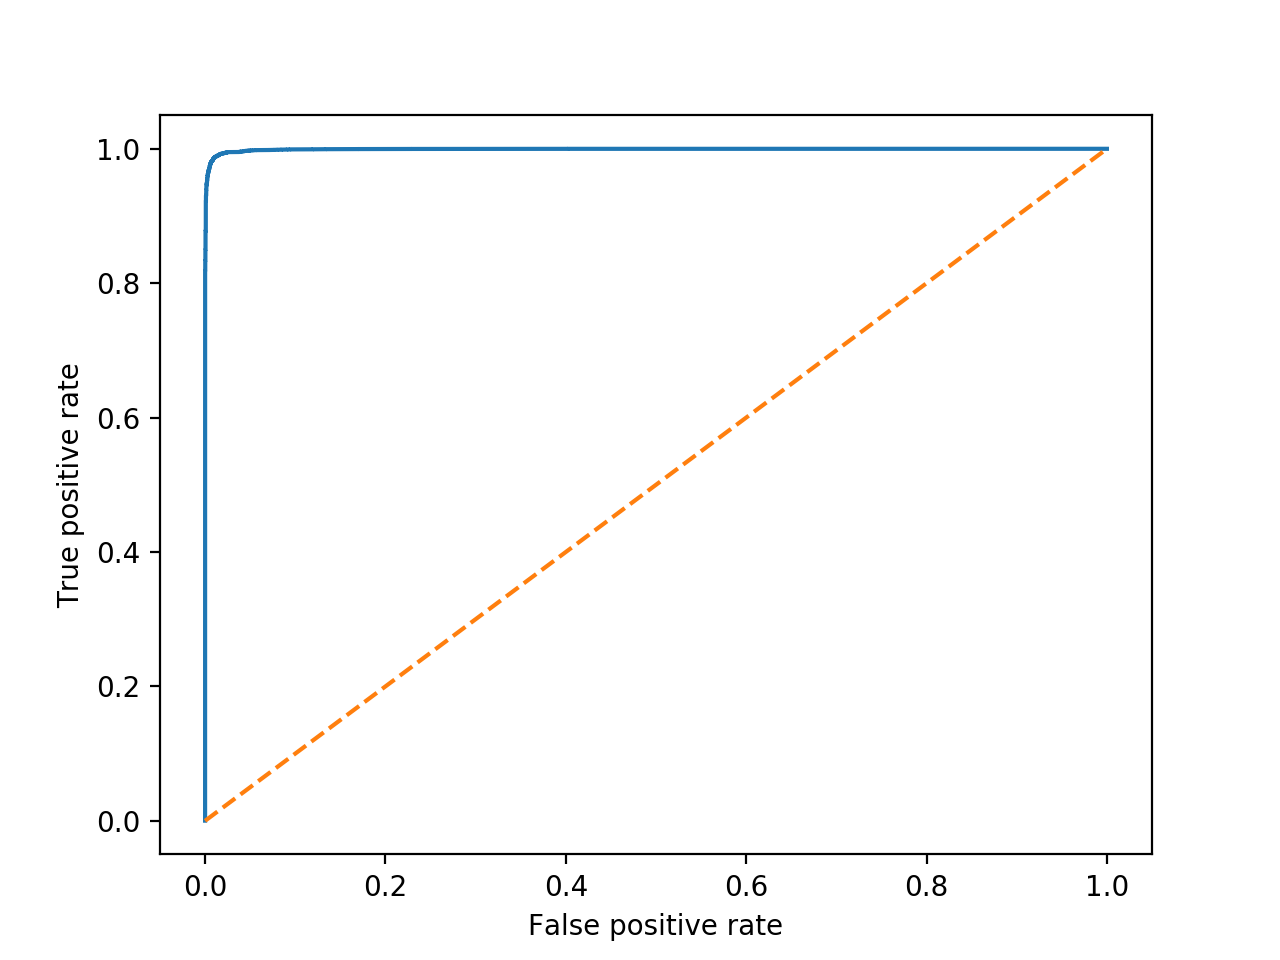

In [22]:
# Weighted results
summarize_metrics(test_labels, test_output, weights=test_weights, threshold=0.999)

<IPython.core.display.Javascript object>


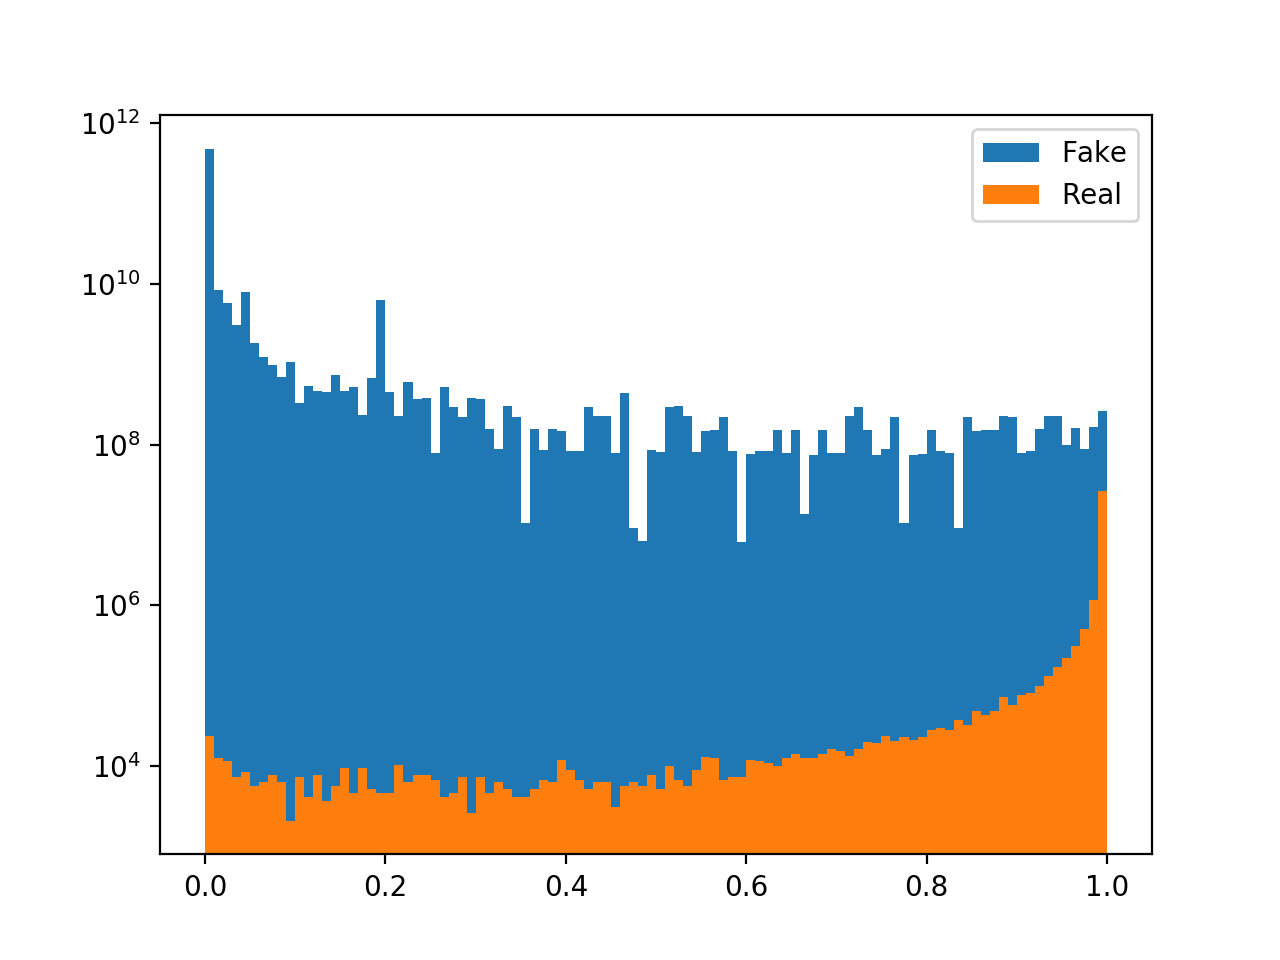

In [31]:
# Visualize the model output
plt.figure()

# Select real/fake sample model outputs
real_idx = test_labels > 0.5
fake_idx = (real_idx == False)

binning=dict(bins=100, range=(0, 1), log=True)
plt.hist(test_output[fake_idx], weights=test_weights[fake_idx], label='Fake', **binning)
plt.hist(test_output[real_idx], weights=test_weights[real_idx], label='Real', **binning)
plt.legend(loc=0);